In [1]:
import sys,os
sys.path.insert(0,os.path.abspath('../prosodic'))
sys.path.insert(0,os.path.abspath('../cadence'))
import cadence as cd
from cadence.imports import *
import plotnine as p9
import prosodic as p
p.config['print_to_screen']=0
SCORECOL_HAYES='Score (Author A bottom-up coding)'

## Gathering data

### Hayes' data

In [2]:
@cache
def read_hayes_df():
    return pd.read_csv(
        'https://linguistics.ucla.edu/people/hayes/ShakespeareAndMilton/ShakespeareTableaux.txt',
        sep='\t', 
        header=7
    )

# read_hayes_df()

### Data parsed via 'stanza'

In [3]:

def getparses(fn='data.parsed.shakespeare.pkl',scorecol=SCORECOL_HAYES):
    if not os.path.exists(fn):
        df = read_hayes_df()
        print(df.columns)
        txt='\n'.join(df.Line)
        t = cd.Verse(txt)
        dfparses = t.parse(verbose=False, num_proc=8)    
        dfl = to_lines(dfparses, only_best=False)
        dfl.to_pickle(fn)
    else:
        dfl=pd.read_pickle(fn)

    df = read_hayes_df()
    dfl['hayes_score'] = [df.iloc[i-1][scorecol] for i in dfl.index.get_level_values('unit_i')]
    return dfl

# getparses()

In [4]:
def getparses_stats():
    dfl = getparses()
    dflq = dfl.groupby('unit_i').mean()
    return dflq

# getparses_stats()

#### Which best correlates?

In [44]:
getparses_stats().corr().hayes_score.sort_values(ascending=False)

hayes_score      1.000000
*w_stressed      0.422671
*total           0.351239
*unres_across    0.323188
num_parses       0.255213
*w_peak          0.129032
*unres_within    0.127973
*s_unstressed    0.044227
Name: hayes_score, dtype: float64

### Data parsed via Prosodic

In [35]:
def getparses_prosodic(fn='data.parsed.shakespeare.prosodic.pkl', force=False, meter='default_english', scorecol=SCORECOL_HAYES):
    if force or not os.path.exists(fn):
        df = read_hayes_df()
        txt='\n'.join(df.Line)
        t = p.Text(txt, phrasebreak='line', name='shakespeare_hayes')
        t.parse(meter=meter)
        for _ in t.stats(): pass
        ifn=os.path.join(p.dir_prosodic_home, 'results', 'stats', 'texts', t.name, f'{t.name}.lines_ot.meter={meter}.csv')
        dfl = pd.read_csv(ifn).fillna(method='ffill')
        dfl.to_pickle(fn)
    else:
        dfl=pd.read_pickle(fn)


    numparsed = {line:len(linedf) for line,linedf in dfl.groupby('line')}
    dfl['num_parses'] = [numparsed.get(line) for line in dfl.line]
    df = read_hayes_df()
    dfl['hayes_score'] = [df.iloc[i-1][scorecol] for i in dfl.num_line]
    return dfl


In [37]:
getparses_prosodic()

,line,parse,meter,num_viols,score_viols,[*strength.w=>-p],[*stress.s=>-u],[*stress.w=>-p],[*footmin-w-resolution],[*footmin-f-resolution],num_line,num_stanza,num_parses,hayes_score
0,"From fairest creatures we desire increase,",from|FAI|rest|CREA|tures|WE|de|SIRE|in|CREASE,wswswswsws,0,0,NaN,NaN,NaN,NaN,NaN,1,1,1,0.28
1,"That thereby beauty's rose might never die,",that|THE|reby*|BEA|uty's|ROSE|might|NE|ver|DIE,wswswswsws,1,1,NaN,NaN,1.0,NaN,NaN,2,1,1,3.73
2,"But as the riper should by time decease,",BUT*|as.the|RI|per|SHOULD|by|TIME|de|CEASE,swwswswsws,1,1,NaN,1.0,1.0,NaN,NaN,3,1,2,1.35
3,"But as the riper should by time decease,",but|AS*|the|RI|per|SHOULD|by|TIME|de|CEASE,wswswswsws,1,1,NaN,1.0,1.0,NaN,NaN,3,1,2,1.35
4,His tender heir might bear his memory:,his|TEN|der|HEIR|might|BEAR|his|ME|mo|RY*,wswswswsws,1,1,NaN,1.0,1.0,NaN,NaN,4,1,3,1.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6001,"Love's fire heats water, water cools not love.",love's*|FI|re|HEATS.WA*|ter|WA|ter|COOLS|not|LOVE,wswsswswsws,2,2,1.0,1.0,1.0,1.0,1.0,2141,1,6,10.68
6002,"Love's fire heats water, water cools not love.",LOVE'S|fire*|HEATS.WA*|ter|WA|ter|COOLS|not|LOVE,swsswswsws,2,2,1.0,1.0,1.0,1.0,1.0,2141,1,6,10.68
6003,"Love's fire heats water, water cools not love.",LOVE'S|fire.heats*|WA|ter|WA|ter|COOLS|not|LOVE,swwswswsws,2,2,1.0,1.0,1.0,1.0,1.0,2141,1,6,10.68
6004,"Love's fire heats water, water cools not love.",LOVE'S.FIRE*|heats*|WA|ter|WA|ter|COOLS|not|LOVE,sswswswsws,2,2,1.0,1.0,1.0,1.0,1.0,2141,1,6,10.68


In [42]:
def getparses_stats_prosodic():
    dfl = getparses_prosodic()
    dflq = dfl.drop(['parse','meter'],axis=1).groupby('line').mean()
    return dflq

In [43]:
getparses_stats_prosodic()

,num_viols,score_viols,[*strength.w=>-p],[*stress.s=>-u],[*stress.w=>-p],[*footmin-w-resolution],[*footmin-f-resolution],num_line,num_stanza,num_parses,hayes_score
line,,,,,,,,,,,
"' Fair, kind, and true,' is all my argument,",2.000000,2.000000,1.0,1.00,1.0,1.000000,1.000000,1466.0,1.0,4.0,10.11
"' Fair, kind, and true,' varying to other words;",3.600000,3.600000,1.0,1.20,1.4,1.000000,1.200000,1467.0,1.0,5.0,10.80
"' Gainst death, and all-oblivious enmity",3.000000,3.000000,1.0,1.25,1.0,1.500000,1.000000,765.0,1.0,8.0,5.24
"' Had my friend's Muse grown with this growing age,",1.000000,1.000000,1.0,1.00,1.0,1.000000,1.000000,444.0,1.0,2.0,8.07
"' Since from thee going, he went wilful-slow,",1.666667,1.666667,1.0,1.00,1.0,1.000000,1.333333,713.0,1.0,3.0,5.43
...,...,...,...,...,...,...,...,...,...,...,...
Your own glass shows you when you look in it.,1.000000,1.000000,1.0,2.00,1.0,1.000000,1.000000,1443.0,1.0,4.0,7.71
"Your shallowest help will hold me up afloat,",2.000000,2.000000,1.0,1.50,1.0,1.000000,1.000000,1115.0,1.0,2.0,4.05
"Yourself again, after yourself's decease,",3.000000,3.000000,1.0,1.00,1.0,1.000000,1.500000,175.0,1.0,4.0,4.91


In [45]:
getparses_stats_prosodic().corr().hayes_score.sort_values(ascending=False)

hayes_score                1.000000
num_viols                  0.366977
score_viols                0.366977
num_parses                 0.264312
num_line                   0.053747
[*footmin-f-resolution]    0.051067
[*stress.w=>-p]            0.036420
[*stress.s=>-u]           -0.003735
[*footmin-w-resolution]   -0.016924
[*strength.w=>-p]         -0.049803
num_stanza                      NaN
Name: hayes_score, dtype: float64

## Figures of correlations

In [59]:
@cache
def getfigdf():
    dflq=getparses_stats_prosodic()
    figdf=dflq.sample(frac=1)
    for c in list(figdf.columns):
        try:
            cats=pd.qcut(figdf[c], 10, duplicates='drop')
            categories = cats.sort_values(ascending=False).drop_duplicates().tolist()
            figdf[f'{c}_bin']=pd.Categorical(cats, categories=categories, ordered=True)
        except Exception:
            pass
    return figdf

In [67]:
# getfigdf()

In [63]:
def plot(x='hayes_score_bin', y='num_parses'):
    return (
        p9.ggplot(getfigdf(), p9.aes(x=x, y=y)) 
        + p9.geom_boxplot(outlier_size=.5, outlier_alpha=.5) 
        + p9.geom_jitter(size=.5, alpha=.1) 
        + p9.coord_flip()
    )

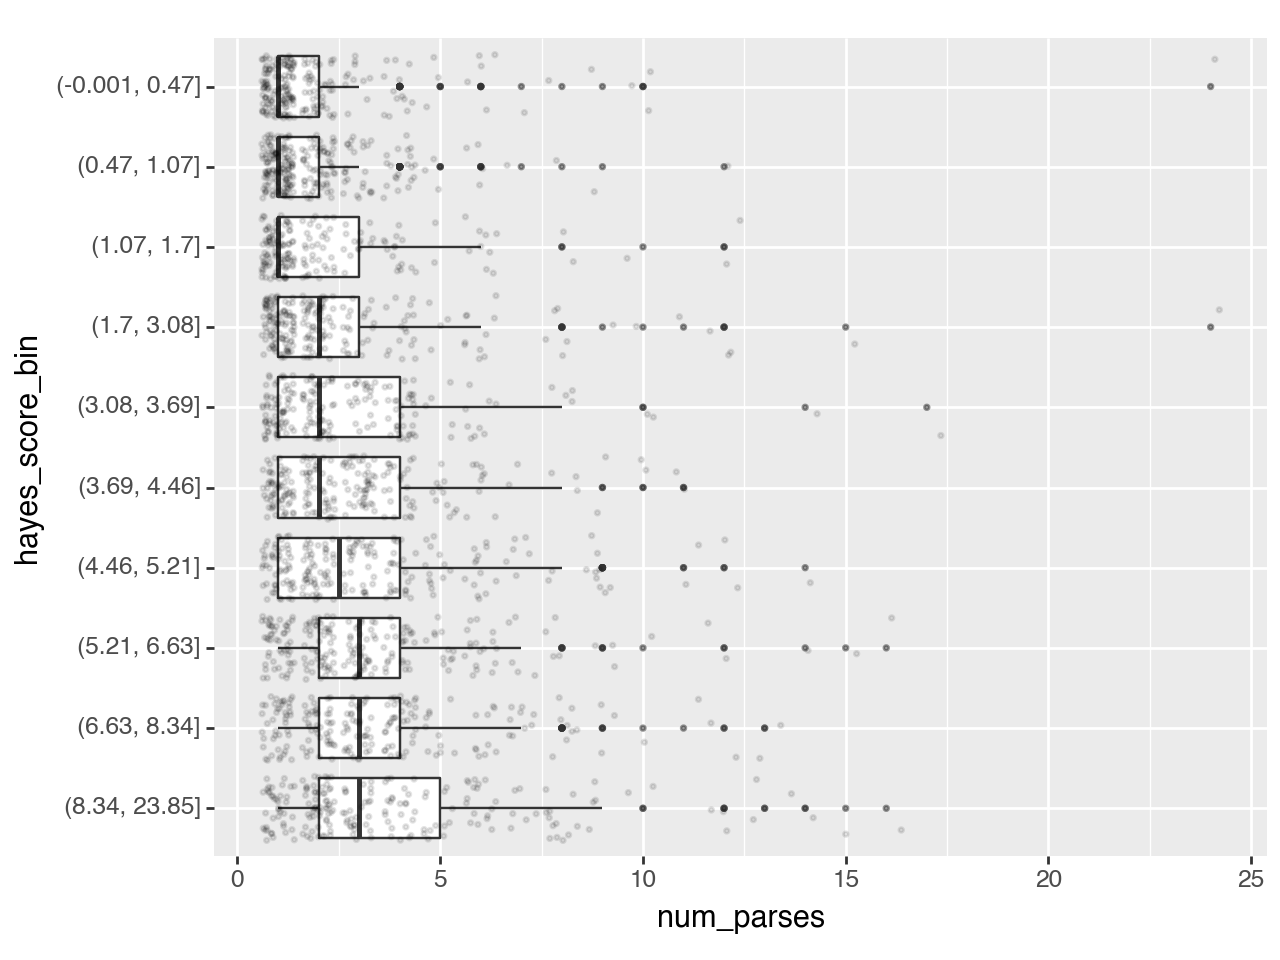

<Figure Size: (640 x 480)>

In [64]:
plot('hayes_score_bin', 'num_parses')

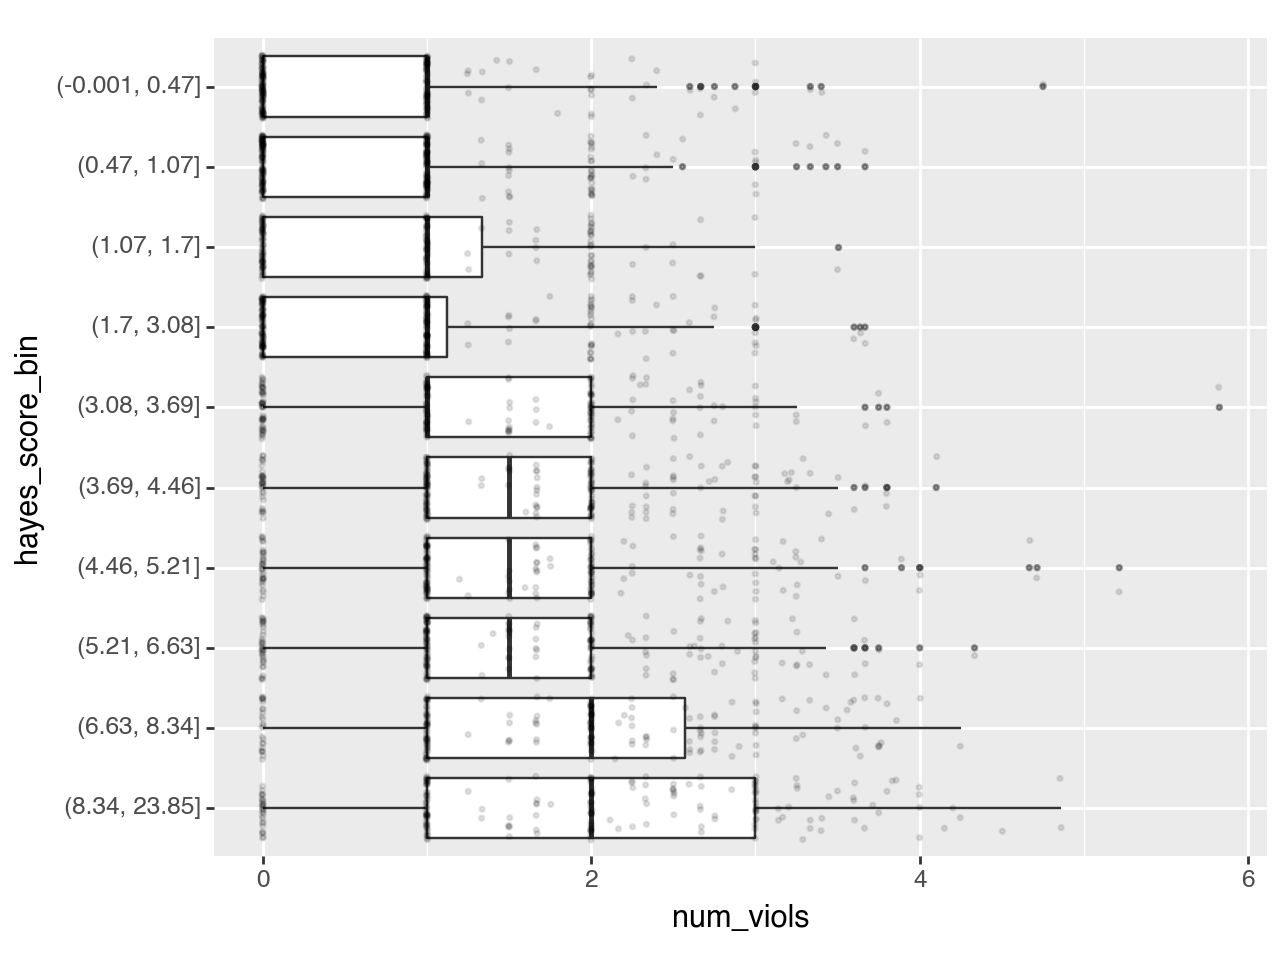

<Figure Size: (640 x 480)>

In [68]:
plot('hayes_score_bin', 'num_viols')